# Knee Osteoarthritis Severity Classifier — Refactored & Enhanced
*Auto-generated on 2025-09-22 08:43:35*

**What's new in this version**
- Clean, modular PyTorch pipeline (training, eval, plots)
- Rich EDA: class balance, sample previews
- **Imbalance handling**: `WeightedRandomSampler` + class-weighted loss
- **Data augmentation** for the minority classes
- More plots: training curves, confusion matrix, ROC & PR curves, per-class metrics
- Reproducibility: seeds, checkpoints, early stopping, AMP
- Ready to extend with Grad-CAM (optional block at the end)


In [18]:
import os, random, math, json, time
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image

from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tqdm import tqdm
import kagglehub

print('PyTorch:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


PyTorch: 2.0.1+cu117


device(type='cuda')

In [64]:
# ===== Config =====
SEED = 42
BATCH_SIZE = 32
NUM_WORKERS = 0
NUM_EPOCHS = 100       # maximum
MIN_EPOCHS = 50        # force at least this many
PATIENCE = 10           # early stopping patience (after 50 epochs)
LR = 3e-4
IMG_SIZE = 224
WEIGHT_DECAY = 1e-4
MODEL_NAME = 'resnet18'

def set_seed(seed=SEED):
    import random, numpy as np, torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)


In [43]:
# ===== Download dataset via kagglehub =====
# Original dataset used in your notebook
# path = kagglehub.dataset_download("shashwatwork/knee-osteoarthritis-dataset-with-severity")
# print("Dataset path:", path)
path = 'Data'
DATA_DIR = Path(path)
TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'
CLASSES = ['0', '1', '2', '3', '4']
len(list(TRAIN_DIR.glob('*/*.png'))) if TRAIN_DIR.exists() else None


5778

In [65]:
# ===== Helpers to load images into a DataFrame =====
def load_dataset_as_dataframe(subdir: str, max_images=None):
    root = TRAIN_DIR.parent / subdir
    rows = []
    for cls in CLASSES:
        cdir = root / cls
        if not cdir.exists():
            continue
        files = sorted([p for p in cdir.iterdir() if p.is_file() and p.suffix.lower() in {'.png', '.jpg', '.jpeg'}])
        if max_images:
            files = files[:max_images]
        for p in files:
            rows.append({'path': str(p), 'label': int(cls)})
    return pd.DataFrame(rows)

train_df = load_dataset_as_dataframe('train')
test_df  = load_dataset_as_dataframe('test')
print(train_df.shape, test_df.shape)
train_df.head()


(5778, 2) (1656, 2)


,path,label
0,Data\train\0\9001695L.png,0
1,Data\train\0\9001897L.png,0
2,Data\train\0\9003126L.png,0
3,Data\train\0\9003126R.png,0
4,Data\train\0\9003430L.png,0


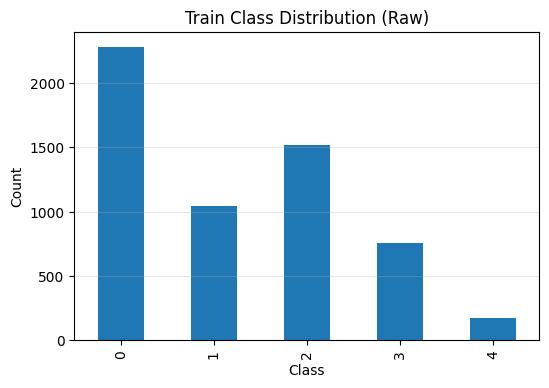

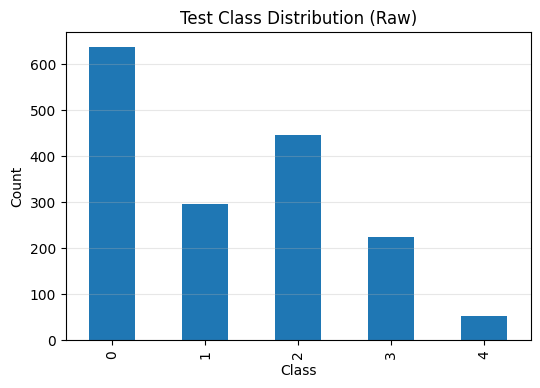

(label
 0    2286
 1    1046
 2    1516
 3     757
 4     173
 Name: count, dtype: int64,
 label
 0    639
 1    296
 2    447
 3    223
 4     51
 Name: count, dtype: int64)

In [66]:
# ===== EDA: class balance =====
def plot_class_distribution(df, title):
    counts = df['label'].value_counts().sort_index()
    plt.figure(figsize=(6,4))
    counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    return counts

train_counts = plot_class_distribution(train_df, 'Train Class Distribution (Raw)')
test_counts  = plot_class_distribution(test_df, 'Test Class Distribution (Raw)')
train_counts, test_counts


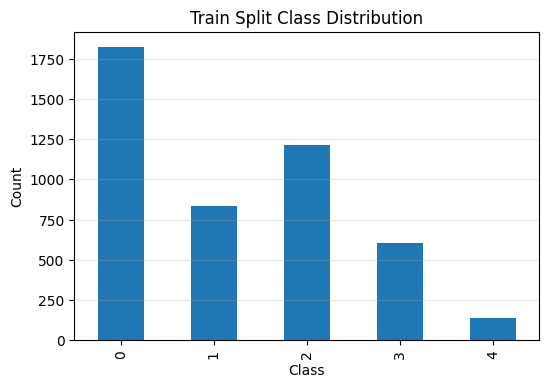

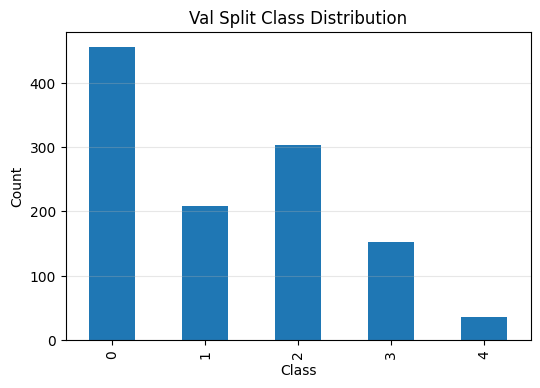

((4622, 2), (1156, 2))

In [67]:
# ===== Train/Val split (stratified) =====
tr_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=SEED)
plot_class_distribution(tr_df, 'Train Split Class Distribution')
plot_class_distribution(val_df, 'Val Split Class Distribution')
tr_df.shape, val_df.shape


In [68]:
# ===== Transforms (augmentation on train) =====
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop((IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.CenterCrop((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [69]:
# ===== PyTorch Dataset =====
class KneeDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['path']).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = int(row['label'])
        return img, label


In [70]:
# ===== Imbalance handling =====
# Compute class counts and weights (inverse frequency)
class_counts = tr_df['label'].value_counts().sort_index()
num_classes = len(CLASSES)
total = class_counts.sum()
class_weights = (total / (num_classes * class_counts)).to_numpy()

# Sample weights per instance
sample_weights = tr_df['label'].map({i: w for i, w in enumerate(class_weights)}).to_numpy()
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

print('Class counts:', class_counts.to_dict())
print('Class weights:', class_weights)


Class counts: {0: 1829, 1: 837, 2: 1213, 3: 605, 4: 138}
Class weights: [0.50541279 1.10442055 0.76207749 1.52793388 6.69855072]


In [71]:
# ===== Dataloaders =====
train_ds = KneeDataset(tr_df, train_tfms)
val_ds   = KneeDataset(val_df, eval_tfms)
test_ds  = KneeDataset(test_df, eval_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

len(train_loader), len(val_loader), len(test_loader)


(145, 37, 52)

In [72]:
# ===== Model =====
def build_model(name='resnet18', num_classes=5, pretrained=True):
    if name == 'resnet18':
        m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        in_feats = m.fc.in_features
        m.fc = nn.Linear(in_feats, num_classes)
    elif name == 'resnet50':
        m = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
        in_feats = m.fc.in_features
        m.fc = nn.Linear(in_feats, num_classes)
    else:
        raise ValueError('Unsupported model name')
    return m

model = build_model(MODEL_NAME, num_classes=len(CLASSES), pretrained=True).to(device)

# Optimizer, loss (with class weights), scheduler
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


In [73]:
# ===== Training & Evaluation Utilities =====
def accuracy_from_logits(logits, targets):
    preds = torch.argmax(logits, dim=1)
    return (preds == targets).float().mean().item()

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_logits = []
    all_targets = []
    running_loss = 0.0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)
        running_loss += loss.item() * imgs.size(0)
        all_logits.append(logits.cpu())
        all_targets.append(labels.cpu())
    all_logits = torch.cat(all_logits)
    all_targets = torch.cat(all_targets)
    acc = accuracy_from_logits(all_logits, all_targets)
    return running_loss / len(loader.dataset), acc, all_logits, all_targets

def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in tqdm(loader, leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
            logits = model(imgs)
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * imgs.size(0)
        running_acc += accuracy_from_logits(logits.detach(), labels) * imgs.size(0)
    n = len(loader.dataset)
    return running_loss / n, running_acc / n


In [74]:
# ===== Training Loop with Early Stopping =====
best_val_acc = -1.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
ckpt_path = 'best_model.pt'

for epoch in range(1, NUM_EPOCHS+1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scaler)
    val_loss, val_acc, _, _ = evaluate(model, val_loader)
    scheduler.step(val_acc)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(optimizer.param_groups[0]['lr'])

    print(f"Epoch {epoch:02d} | "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} | "
          f"lr={optimizer.param_groups[0]['lr']:.2e} | "
          f"{time.strftime('%Mm %Ss', time.gmtime(time.time()-t0))}")

    # Early stopping with min epochs
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'model_state_dict': model.state_dict(),
                    'config': {'classes': CLASSES, 'img_size': IMG_SIZE}}, ckpt_path)
        patience_used = 0
    else:
        patience_used = history.get('patience_used', 0) + 1
    history['patience_used'] = patience_used

    if epoch >= MIN_EPOCHS and patience_used >= PATIENCE:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

print('Best val acc:', best_val_acc)

Epoch 01 | train_loss=0.7005 train_acc=0.4498 | val_loss=0.9242 val_acc=0.4031 | lr=3.00e-04 | 01m 11s


Epoch 02 | train_loss=0.4806 train_acc=0.5612 | val_loss=0.9864 val_acc=0.3780 | lr=3.00e-04 | 01m 12s


Epoch 03 | train_loss=0.4228 train_acc=0.5792 | val_loss=1.0551 val_acc=0.3356 | lr=3.00e-04 | 01m 12s


Epoch 00004: reducing learning rate of group 0 to 1.5000e-04.
Epoch 04 | train_loss=0.3837 train_acc=0.6121 | val_loss=0.8928 val_acc=0.3945 | lr=1.50e-04 | 01m 12s


Epoch 05 | train_loss=0.3639 train_acc=0.6242 | val_loss=0.8651 val_acc=0.4559 | lr=1.50e-04 | 01m 13s


Epoch 06 | train_loss=0.3486 train_acc=0.6346 | val_loss=0.8703 val_acc=0.4308 | lr=1.50e-04 | 01m 11s


Epoch 07 | train_loss=0.3203 train_acc=0.6473 | val_loss=0.9746 val_acc=0.4135 | lr=1.50e-04 | 01m 11s


Epoch 08 | train_loss=0.3167 train_acc=0.6558 | val_loss=0.8142 val_acc=0.5121 | lr=1.50e-04 | 01m 12s


Epoch 09 | train_loss=0.3047 train_acc=0.6765 | val_loss=0.8582 val_acc=0.5623 | lr=1.50e-04 | 01m 12s


Epoch 10 | train_loss=0.2886 train_acc=0.6798 | val_loss=0.8600 val_acc=0.4481 | lr=1.50e-04 | 01m 11s


Epoch 11 | train_loss=0.2998 train_acc=0.6789 | val_loss=0.8401 val_acc=0.4983 | lr=1.50e-04 | 01m 11s


Epoch 00012: reducing learning rate of group 0 to 7.5000e-05.
Epoch 12 | train_loss=0.2982 train_acc=0.6822 | val_loss=0.8360 val_acc=0.5173 | lr=7.50e-05 | 01m 12s


Epoch 13 | train_loss=0.2635 train_acc=0.7125 | val_loss=0.7794 val_acc=0.6012 | lr=7.50e-05 | 01m 12s


Epoch 14 | train_loss=0.2360 train_acc=0.7231 | val_loss=0.8472 val_acc=0.5536 | lr=7.50e-05 | 01m 12s


Epoch 15 | train_loss=0.2346 train_acc=0.7384 | val_loss=0.8441 val_acc=0.5069 | lr=7.50e-05 | 01m 12s


Epoch 00016: reducing learning rate of group 0 to 3.7500e-05.
Epoch 16 | train_loss=0.2400 train_acc=0.7376 | val_loss=0.8615 val_acc=0.5363 | lr=3.75e-05 | 01m 12s


Epoch 17 | train_loss=0.2154 train_acc=0.7525 | val_loss=0.8334 val_acc=0.5908 | lr=3.75e-05 | 01m 12s


Epoch 18 | train_loss=0.1952 train_acc=0.7746 | val_loss=0.8426 val_acc=0.5952 | lr=3.75e-05 | 01m 11s


Epoch 00019: reducing learning rate of group 0 to 1.8750e-05.
Epoch 19 | train_loss=0.2014 train_acc=0.7709 | val_loss=0.8246 val_acc=0.5995 | lr=1.87e-05 | 01m 12s


Epoch 20 | train_loss=0.1918 train_acc=0.7919 | val_loss=0.8442 val_acc=0.5943 | lr=1.87e-05 | 01m 11s


Epoch 21 | train_loss=0.1833 train_acc=0.7893 | val_loss=0.8984 val_acc=0.5649 | lr=1.87e-05 | 01m 12s


Epoch 00022: reducing learning rate of group 0 to 9.3750e-06.
Epoch 22 | train_loss=0.1980 train_acc=0.7847 | val_loss=0.8945 val_acc=0.5796 | lr=9.37e-06 | 01m 12s


Epoch 23 | train_loss=0.1734 train_acc=0.8020 | val_loss=0.8617 val_acc=0.5900 | lr=9.37e-06 | 01m 11s


Epoch 24 | train_loss=0.1805 train_acc=0.7979 | val_loss=0.8843 val_acc=0.5891 | lr=9.37e-06 | 01m 12s


Epoch 25 | train_loss=0.1716 train_acc=0.8064 | val_loss=0.8829 val_acc=0.6064 | lr=9.37e-06 | 01m 12s


Epoch 26 | train_loss=0.1726 train_acc=0.7958 | val_loss=0.8752 val_acc=0.6176 | lr=9.37e-06 | 01m 12s


Epoch 27 | train_loss=0.1801 train_acc=0.7990 | val_loss=0.8870 val_acc=0.5761 | lr=9.37e-06 | 01m 11s


Epoch 28 | train_loss=0.1701 train_acc=0.8096 | val_loss=0.9034 val_acc=0.5796 | lr=9.37e-06 | 01m 11s


Epoch 00029: reducing learning rate of group 0 to 4.6875e-06.
Epoch 29 | train_loss=0.1717 train_acc=0.8129 | val_loss=0.8986 val_acc=0.5848 | lr=4.69e-06 | 01m 11s


Epoch 30 | train_loss=0.1620 train_acc=0.8174 | val_loss=0.9031 val_acc=0.5856 | lr=4.69e-06 | 01m 11s


Epoch 31 | train_loss=0.1587 train_acc=0.8267 | val_loss=0.9121 val_acc=0.5900 | lr=4.69e-06 | 01m 11s


Epoch 00032: reducing learning rate of group 0 to 2.3437e-06.
Epoch 32 | train_loss=0.1539 train_acc=0.8273 | val_loss=0.9009 val_acc=0.5969 | lr=2.34e-06 | 01m 11s


Epoch 33 | train_loss=0.1581 train_acc=0.8256 | val_loss=0.9178 val_acc=0.5978 | lr=2.34e-06 | 01m 12s


Epoch 34 | train_loss=0.1578 train_acc=0.8191 | val_loss=0.9310 val_acc=0.5943 | lr=2.34e-06 | 01m 11s


Epoch 00035: reducing learning rate of group 0 to 1.1719e-06.
Epoch 35 | train_loss=0.1499 train_acc=0.8282 | val_loss=0.9322 val_acc=0.5960 | lr=1.17e-06 | 01m 11s


Epoch 36 | train_loss=0.1673 train_acc=0.8105 | val_loss=0.9259 val_acc=0.5891 | lr=1.17e-06 | 01m 11s


Epoch 37 | train_loss=0.1482 train_acc=0.8379 | val_loss=0.9244 val_acc=0.5934 | lr=1.17e-06 | 01m 11s


Epoch 00038: reducing learning rate of group 0 to 5.8594e-07.
Epoch 38 | train_loss=0.1517 train_acc=0.8204 | val_loss=0.9270 val_acc=0.5943 | lr=5.86e-07 | 01m 11s


Epoch 39 | train_loss=0.1520 train_acc=0.8183 | val_loss=0.9348 val_acc=0.5761 | lr=5.86e-07 | 01m 11s


Epoch 40 | train_loss=0.1633 train_acc=0.8232 | val_loss=0.9244 val_acc=0.6029 | lr=5.86e-07 | 01m 11s


Epoch 00041: reducing learning rate of group 0 to 2.9297e-07.
Epoch 41 | train_loss=0.1528 train_acc=0.8334 | val_loss=0.9230 val_acc=0.5934 | lr=2.93e-07 | 01m 11s


Epoch 42 | train_loss=0.1488 train_acc=0.8306 | val_loss=0.9290 val_acc=0.5960 | lr=2.93e-07 | 01m 11s


Epoch 43 | train_loss=0.1631 train_acc=0.8180 | val_loss=0.9132 val_acc=0.5900 | lr=2.93e-07 | 01m 11s


Epoch 00044: reducing learning rate of group 0 to 1.4648e-07.
Epoch 44 | train_loss=0.1486 train_acc=0.8256 | val_loss=0.9370 val_acc=0.6081 | lr=1.46e-07 | 01m 12s


Epoch 45 | train_loss=0.1500 train_acc=0.8351 | val_loss=0.9286 val_acc=0.6099 | lr=1.46e-07 | 01m 11s


Epoch 46 | train_loss=0.1479 train_acc=0.8354 | val_loss=0.9228 val_acc=0.6003 | lr=1.46e-07 | 01m 12s


Epoch 00047: reducing learning rate of group 0 to 7.3242e-08.
Epoch 47 | train_loss=0.1587 train_acc=0.8243 | val_loss=0.9297 val_acc=0.6029 | lr=7.32e-08 | 01m 15s


Epoch 48 | train_loss=0.1566 train_acc=0.8273 | val_loss=0.9182 val_acc=0.5986 | lr=7.32e-08 | 01m 12s


Epoch 49 | train_loss=0.1542 train_acc=0.8345 | val_loss=0.9228 val_acc=0.6038 | lr=7.32e-08 | 01m 09s


Epoch 00050: reducing learning rate of group 0 to 3.6621e-08.
Epoch 50 | train_loss=0.1617 train_acc=0.8280 | val_loss=0.9257 val_acc=0.5978 | lr=3.66e-08 | 01m 08s
Early stopping triggered at epoch 50.
Best val acc: 0.6176470518112183


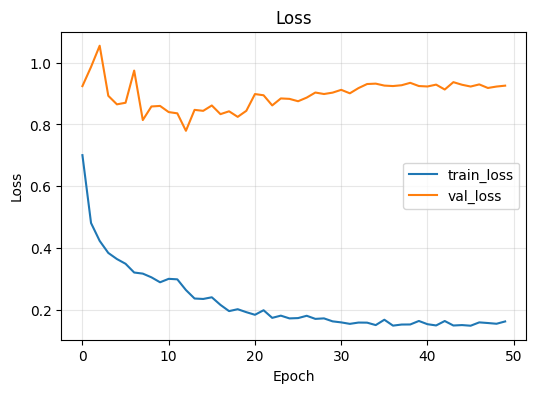

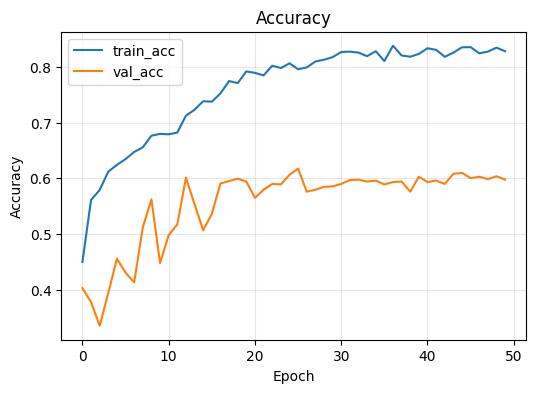

In [75]:
# ===== Training Curves =====
def plot_curves(history):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(history['train_loss'], label='train_loss')
    ax.plot(history['val_loss'], label='val_loss')
    ax.set_title('Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.show()

    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(history['train_acc'], label='train_acc')
    ax.plot(history['val_acc'], label='val_acc')
    ax.set_title('Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.show()

plot_curves(history)


VAL  loss=0.8752 acc=0.6176
TEST loss=0.9327 acc=0.6184


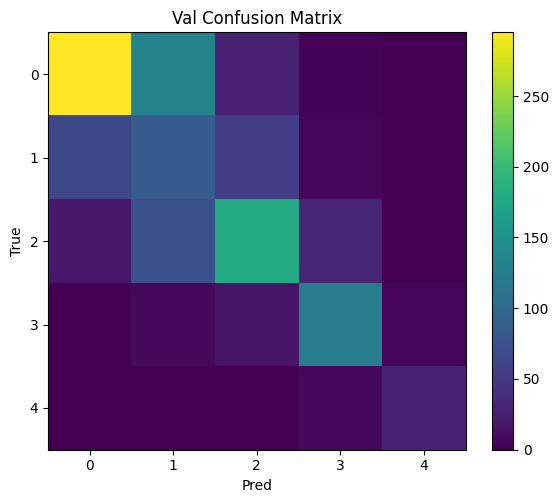

              precision    recall  f1-score   support

           0     0.7804    0.6455    0.7066       457
           1     0.2886    0.4115    0.3393       209
           2     0.6475    0.5941    0.6196       303
           3     0.7381    0.8158    0.7750       152
           4     0.8529    0.8286    0.8406        35

    accuracy                         0.6176      1156
   macro avg     0.6615    0.6591    0.6562      1156
weighted avg     0.6533    0.6176    0.6304      1156



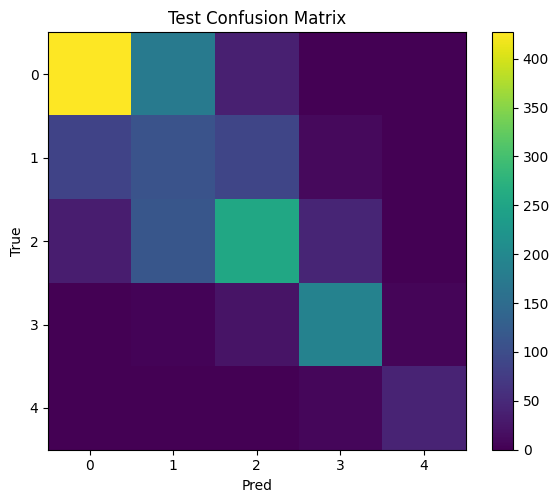

              precision    recall  f1-score   support

           0     0.7806    0.6682    0.7201       639
           1     0.2730    0.3716    0.3147       296
           2     0.6303    0.5682    0.5976       447
           3     0.7480    0.8520    0.7966       223
           4     0.8776    0.8431    0.8600        51

    accuracy                         0.6184      1656
   macro avg     0.6619    0.6606    0.6578      1656
weighted avg     0.6479    0.6184    0.6292      1656



In [76]:
# ===== Evaluation: Confusion Matrix & Classification Report =====
ckpt = torch.load('best_model.pt', map_location=device)
model.load_state_dict(ckpt['model_state_dict'])

val_loss, val_acc, val_logits, val_targets = evaluate(model, val_loader)
test_loss, test_acc, test_logits, test_targets = evaluate(model, test_loader)

print(f"VAL  loss={val_loss:.4f} acc={val_acc:.4f}")
print(f"TEST loss={test_loss:.4f} acc={test_acc:.4f}")

def plot_confusion(y_true, logits, title):
    y_pred = torch.argmax(logits, dim=1).numpy()
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASSES))))
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=CLASSES, yticklabels=CLASSES, ylabel='True', xlabel='Pred')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    print(classification_report(y_true, y_pred, digits=4))

plot_confusion(val_targets.numpy(), val_logits, 'Val Confusion Matrix')
plot_confusion(test_targets.numpy(), test_logits, 'Test Confusion Matrix')


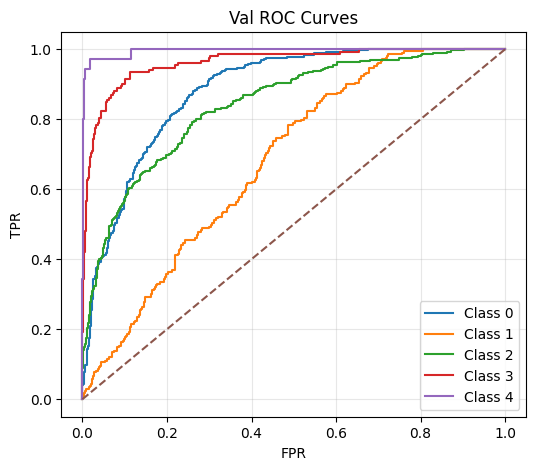

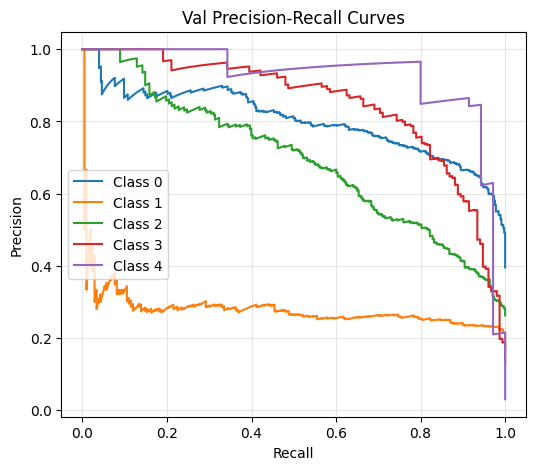

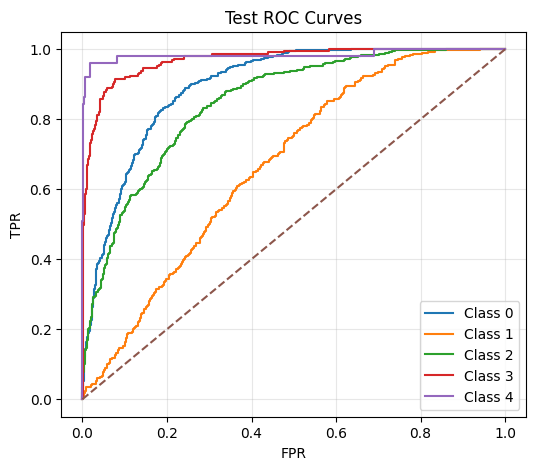

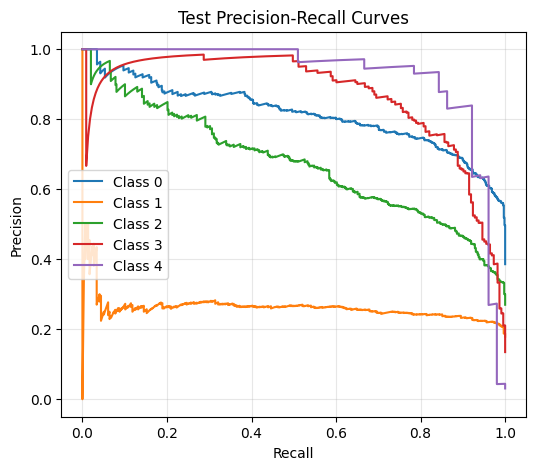

In [77]:
# ===== ROC & PR Curves (One-vs-Rest) =====
def plot_roc_pr(logits, targets, title_prefix='Val'):
    y_true = np.eye(len(CLASSES))[targets.numpy()]
    probs = torch.softmax(logits, dim=1).numpy()

    # ROC AUC per class
    fig, ax = plt.subplots(figsize=(6,5))
    for i in range(len(CLASSES)):
        fpr, tpr, _ = roc_curve(y_true[:, i], probs[:, i])
        ax.plot(fpr, tpr, label=f'Class {i}')
    ax.plot([0,1],[0,1],'--')
    ax.set_title(f'{title_prefix} ROC Curves')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.show()

    # PR Curves per class
    fig, ax = plt.subplots(figsize=(6,5))
    for i in range(len(CLASSES)):
        prec, rec, _ = precision_recall_curve(y_true[:, i], probs[:, i])
        ax.plot(rec, prec, label=f'Class {i}')
    ax.set_title(f'{title_prefix} Precision-Recall Curves')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.show()

plot_roc_pr(val_logits, val_targets, 'Val')
plot_roc_pr(test_logits, test_targets, 'Test')


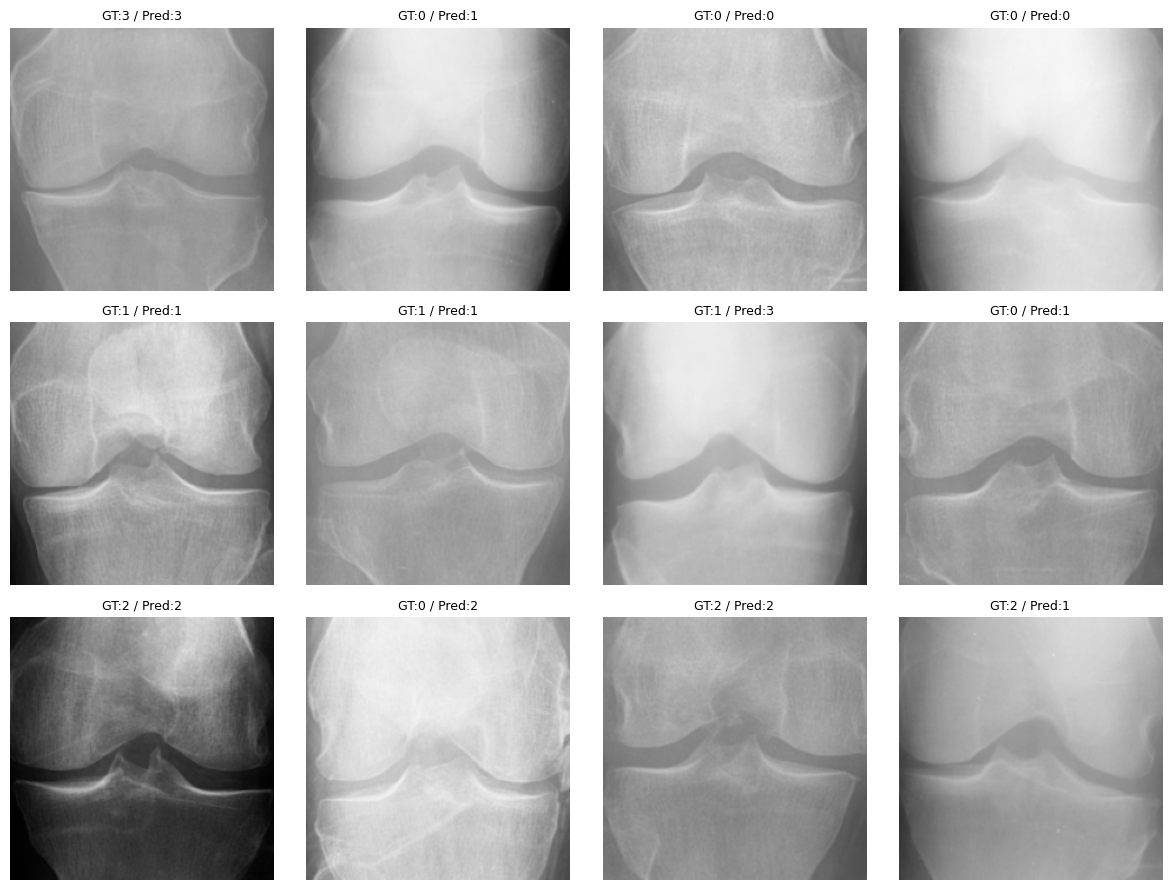

In [57]:
# ===== Qualitative: sample predictions =====
@torch.no_grad()
def show_samples(loader, n=12):
    model.eval()
    images, gts, preds = [], [], []
    count = 0
    for imgs, labels in loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        pred = torch.argmax(logits, dim=1).cpu().numpy()
        for i in range(imgs.size(0)):
            if count >= n: break
            img = imgs[i].cpu()
            # de-normalize for display
            mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
            std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
            img = img*std + mean
            images.append(img.permute(1,2,0).numpy())
            gts.append(int(labels[i]))
            preds.append(int(pred[i]))
            count += 1
        if count >= n: break
    cols = 4
    rows = math.ceil(n/cols)
    plt.figure(figsize=(cols*3, rows*3))
    for i in range(n):
        if i>=len(images): break
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(np.clip(images[i],0,1))
        ax.set_title(f"GT:{gts[i]} / Pred:{preds[i]}", fontsize=9)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_samples(val_loader, n=12)


In [58]:
# ===== Save artifacts =====
torch.save(model.state_dict(), 'final_model_state_dict.pt')
with open('label_map.json', 'w') as f:
    json.dump({'classes': CLASSES}, f, indent=2)
print('Saved: best_model.pt, final_model_state_dict.pt, label_map.json')


Saved: best_model.pt, final_model_state_dict.pt, label_map.json


## Optional: Grad-CAM
Install `pytorch-grad-cam` and visualize important regions. Uncomment and run:
```python
!pip -q install pytorch-grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [model.layer4[-1]]  # for ResNet
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=(device.type=='cuda'))
imgs, labels = next(iter(val_loader))
rgb_imgs = imgs.clone()
rgb_imgs = rgb_imgs*torch.tensor([0.229,0.224,0.225]).view(3,1,1) + torch.tensor([0.485,0.456,0.406]).view(3,1,1)
rgb_imgs = torch.clamp(rgb_imgs,0,1)
targets = [ClassifierOutputTarget(int(labels[0]))]
grayscale_cam = cam(input_tensor=imgs.to(device)[:1], targets=targets)[0]
viz = show_cam_on_image(rgb_imgs[0].permute(1,2,0).numpy(), grayscale_cam, use_rgb=True)
plt.imshow(viz); plt.axis('off')
```

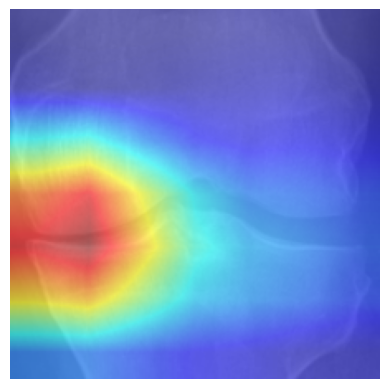

In [78]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# pick last ResNet block
target_layers = [model.layer4[-1]]  

cam = GradCAM(model=model, target_layers=target_layers)

# one batch from val loader
imgs, labels = next(iter(val_loader))

# normalize back to RGB for visualization
mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
rgb_imgs = imgs.clone() * std + mean
rgb_imgs = torch.clamp(rgb_imgs,0,1)

# run GradCAM
targets = [ClassifierOutputTarget(int(labels[0]))]
grayscale_cam = cam(input_tensor=imgs.to(device)[:1], targets=targets)[0]

# overlay
viz = show_cam_on_image(rgb_imgs[0].permute(1,2,0).numpy(), grayscale_cam, use_rgb=True)
plt.imshow(viz); plt.axis('off'); plt.show()
